# Online_Shoppers_intention

Resumen: 
    
He partido de un supuesto de negocio en el que se quieren clasificar correctamente el mayor número posible de    compradores en tiempo real para poder dirigir promociones a los no compradores, por lo que el Recall ha sido la métrica a la que más importancia le he dado. Hay modelos que han dado una excelente tasa AUC, pero cuando se analiza el Recall se ve que son modelos deficientes para este supuesto. Por ello se han probado múltiples modelos, umbrales, configuraciones, nuevas features, etc. El presente notebook es un resumen tras haber descartado modelos, features y configuraciones no satisfactorias.

   Modelos probados: Regresión logística, KNN, Random Forest y Keras.
   El modelo que mejores predicciones ha dado ha sido Random Forest AUC train =  0.93
   AUC test =  0.9, con un umbral de 0.2 da un Recall: 0.7990
   Se han probado diferentes combinaciones de umbrales y configuraciones según el modelo.
   Se han creado nuevas features, lo cual no ha variado el resultado demasiado, solo en KNN ha sido significativo.
   Se ha probado el dataset con todas sus características y también con el método SelectKBest para elegir las 10 mejores.
   También se ha eliminado la columna 'Month' para evitar el sesgo de Black Friday y otras fechas relevantes.

Estructura del dataset: El conjunto de datos contiene 12,330 filas y 18 columnas, incluyendo variables numéricas y categóricas relacionadas con el comportamiento de los usuarios en un sitio web de comercio electrónico

Ausencia de valores nulos: No se encontraron valores nulos en el dataset, lo que facilita el análisis sin necesidad de imputación de datos

Comportamiento de compra: Los usuarios que realizan compras tienden a pasar más tiempo en el sitio y visitar más páginas, especialmente en las secciones administrativa, informativa y relacionada con productos

Variables relevantes: BounceRates, ExitRates, PageValues y SpecialDay muestran una relación significativa con la variable objetivo Revenue

Importancia de SpecialDay: En días especiales, alrededor del 40% del tráfico resulta en compras, lo cual es muy significativo

Correlaciones: Se identificaron fuertes correlaciones entre ProductRelated_Duration y ProductRelated, así como entre ExitRates y BounceRates


In [2]:
# Importación de librerias

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import AUC, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input


In [3]:
# Definición de funciones

def represento_curva_roc(y, y_prob, title):
    
    fpr, tpr, threshold = roc_curve(y, y_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Código principal

In [4]:
# Cargamos dataset

df = pd.read_csv("online_shoppers_intention.csv", sep=',')

# Análisis descriptivo

In [5]:
df.shape

(12330, 18)

In [6]:
df.head() 

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [7]:
df.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

In [8]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


El dataset `online_shoppers_intention.csv` contiene información sobre el comportamiento de los usuarios en un sitio web de comercio electrónico. 

1. **Administrative (int64)**: 
   - Número de páginas administrativas visitadas por el usuario. Estas páginas suelen incluir secciones como "Contactos", "Acerca de nosotros", "Términos y condiciones", etc.

2. **Administrative_Duration (float64)**:
   - Tiempo total (en segundos) que el usuario pasó en las páginas administrativas durante la sesión.

3. **Informational (int64)**:
   - Número de páginas informativas visitadas por el usuario. Estas páginas proporcionan información general, como guías de compra, preguntas frecuentes, etc.

4. **Informational_Duration (float64)**:
   - Tiempo total (en segundos) que el usuario pasó en las páginas informativas durante la sesión.

5. **ProductRelated (int64)**:
   - Número de páginas relacionadas con productos que el usuario visitó. Estas páginas suelen ser páginas de productos específicos, descripciones, reseñas, etc.

6. **ProductRelated_Duration (float64)**:
   - Tiempo total (en segundos) que el usuario pasó en páginas relacionadas con productos.

7. **BounceRates (float64)**:
   - Tasa de rebote para esa sesión. Representa el porcentaje de visitantes que entran al sitio y se van sin interactuar con la página (es decir, sin hacer clic en otra página).

8. **ExitRates (float64)**:
   - Tasa de salida para esa sesión. Indica el porcentaje de veces que una página en particular fue la última vista por los visitantes en su sesión.

9. **PageValues (float64)**:
   - Valor de la página calculado para esa sesión. Este valor se asocia con la contribución de la página a la posibilidad de conversión (es decir, compra).

10. **SpecialDay (float64)**:
    - Proximidad del día en que se realizó la sesión a un día especial (como el Día de San Valentín o Navidad). El valor está normalizado entre 0 y 1, donde 1 indica que la sesión se realizó en un día especial.

11. **Month (object)**:
    - Mes del año en que se realizó la sesión. Generalmente representado como un texto con el nombre del mes o su abreviatura.

12. **OperatingSystems (int64)**:
    - Identificador del sistema operativo que utilizó el usuario durante la sesión (por ejemplo, Windows, MacOS, etc.).

13. **Browser (int64)**:
    - Identificador del navegador web que utilizó el usuario durante la sesión (por ejemplo, Chrome, Firefox, etc.).

14. **Region (int64)**:
    - Identificador de la región geográfica del usuario. Las regiones están categorizadas numéricamente.

15. **TrafficType (int64)**:
    - Identificador del tipo de tráfico que trajo al usuario al sitio web (por ejemplo, tráfico directo, tráfico de búsqueda, referencias, etc.).

16. **VisitorType (object)**:
    - Tipo de visitante, categorizado como "New_Visitor" (nuevo visitante), "Returning_Visitor" (visitante recurrente), o "Other" (otro).

17. **Weekend (bool)**:
    - Indicador booleano que muestra si la sesión se realizó en fin de semana o no. Los valores son `True` (si fue en fin de semana) y `False` (si fue entre semana).

18. **Revenue (bool)**:
    - Indicador booleano que muestra si la sesión resultó en una transacción que generó ingresos. `True` si se realizó una compra y `False` si no se realizó.


In [9]:
# Buscamos los valores nulos, no existe ningún nulo.

df.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [10]:
# Vemos los valores únicos que tiene cada campo. 

for column in df.columns:
    unique_values = df[column].unique()
    num_unique = len(unique_values)
    
    if num_unique > 20:  # Si hay más de 20 valores únicos, muestra un resumen en lugar de todos los valores
        print(f"Columna '{column}' ({num_unique} valores únicos):")
        print(df[column].describe())  # Muestra estadísticas resumidas
    else:
        print(f"Valores únicos en la columna '{column}' ({num_unique} valores únicos):")
        print(unique_values)
    
    print("\n")




Columna 'Administrative' (27 valores únicos):
count    12330.000000
mean         2.315166
std          3.321784
min          0.000000
25%          0.000000
50%          1.000000
75%          4.000000
max         27.000000
Name: Administrative, dtype: float64


Columna 'Administrative_Duration' (3335 valores únicos):
count    12330.000000
mean        80.818611
std        176.779107
min          0.000000
25%          0.000000
50%          7.500000
75%         93.256250
max       3398.750000
Name: Administrative_Duration, dtype: float64


Valores únicos en la columna 'Informational' (17 valores únicos):
[ 0  1  2  4 16  5  3 14  6 12  7  9 10  8 11 24 13]


Columna 'Informational_Duration' (1258 valores únicos):
count    12330.000000
mean        34.472398
std        140.749294
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2549.375000
Name: Informational_Duration, dtype: float64


Columna 'ProductRelated' (311 valores únicos):
count    12

# Visualizaciones

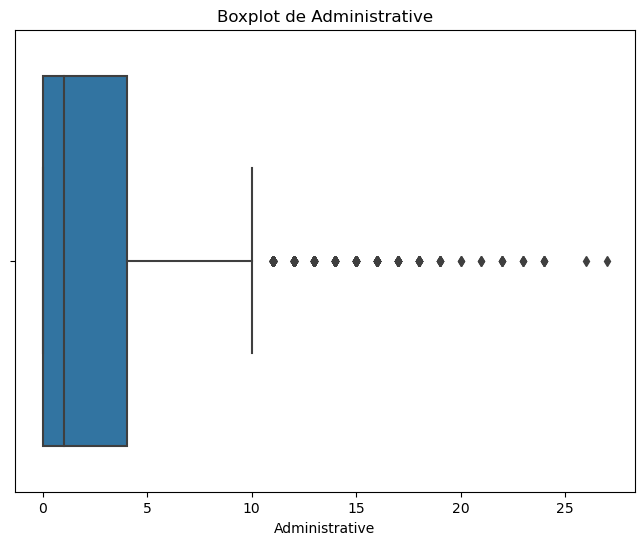

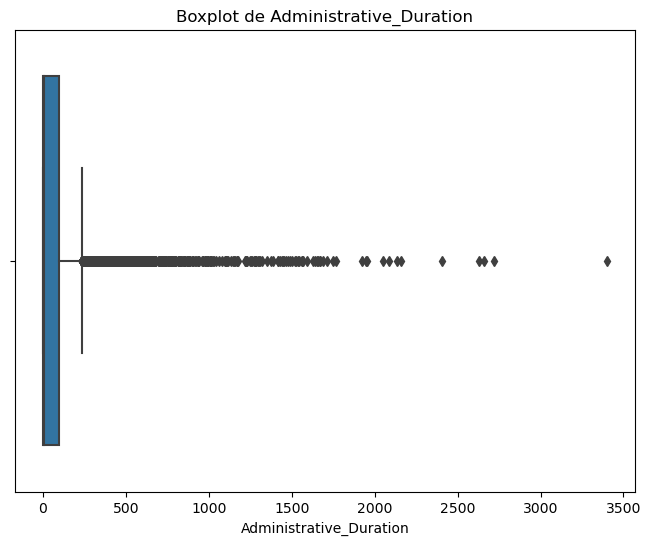

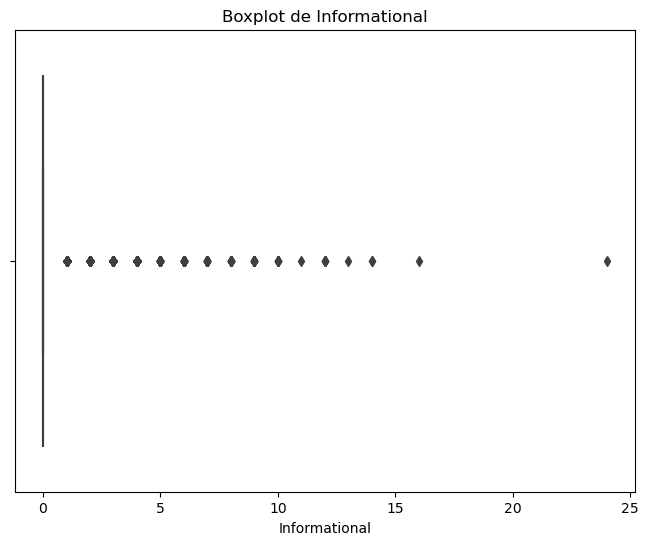

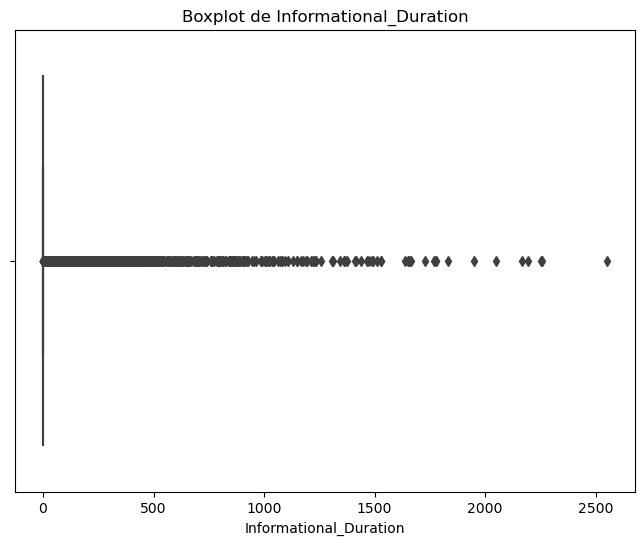

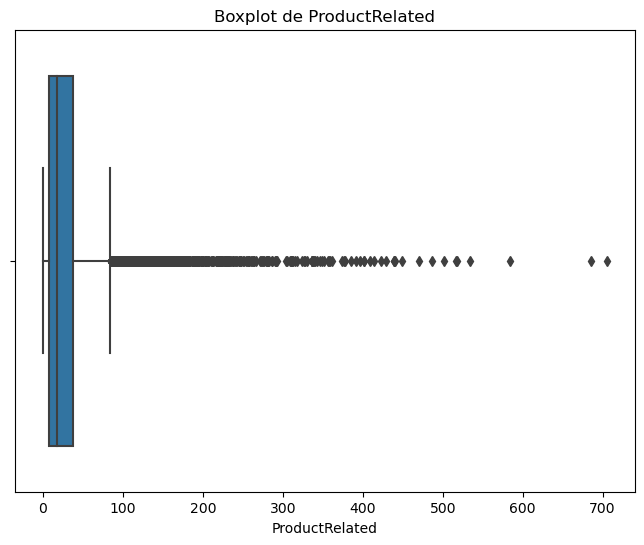

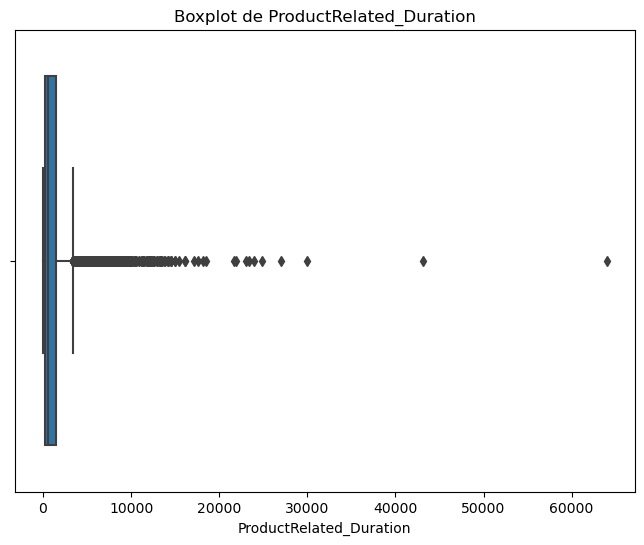

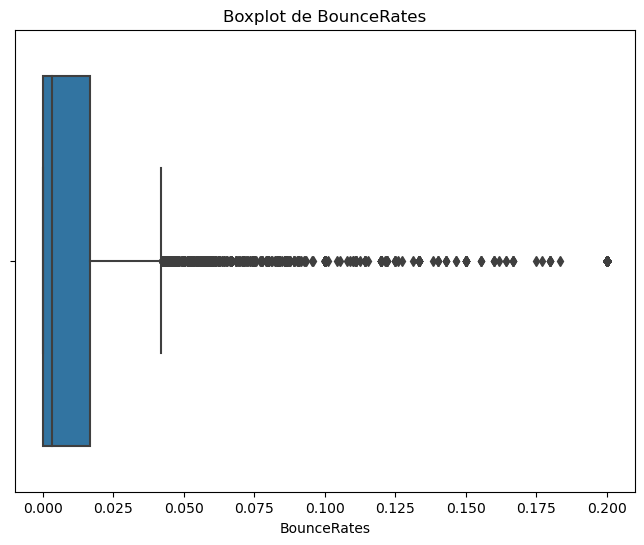

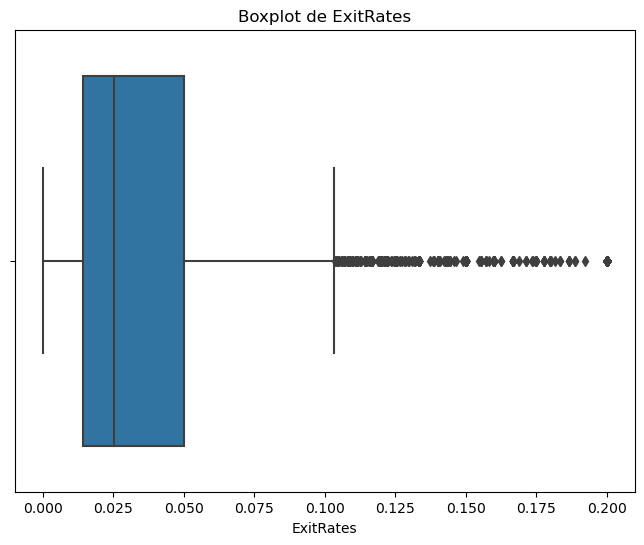

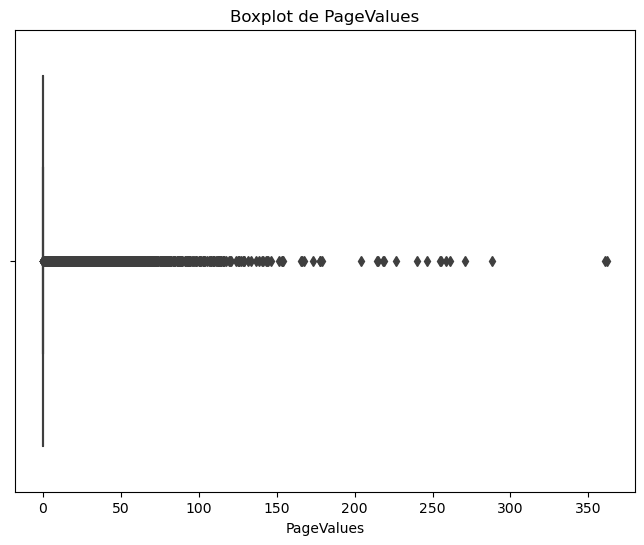

In [11]:
# Buscamos outliers en los campos numéricos que puedan dar lugar a ello mediante la visualización de gráficos boxplots

# Concluyo que los valores alejados pueden ser significativos para los modelos predictivos, no se eliminan. 

var_boxplot = df[['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated',
               'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues']]

for column in var_boxplot:
    plt.figure(figsize=(8, 6))  # Ajustar el tamaño de la figura
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot de {column}')
    plt.show()

Visualizamos gráficos de barras para ver la relación entre la variable target y las variables numéricas que tengan 
sentido, ya que se va a hacer la media de estas últimas.

En las variables  Administrative, Administrative_Duration, Informational, Informational_Duration,  ProductRelated, 
ProductRelated_Duration, se puede ver cómo las personas que acaban comprando han pasado el doble de tiempo o 
han visitado el doble de páginas y han estado el doble de tiempo en ellas que las que no han comprado. 
En cuanto a sentido de negocio, la conversión a la inversa es muy complicada, ya que las personas que han tomado
la decisión de comprar es normal que tengan este comportamiento. Pero decir que si la empresa consigue que las
personas pasen más tiempo en esas páginas administrativas, en consecuencia, vayan a comprar, es una falacia. Lo que sí
puede tener sentido es conseguir que los visitantes estén más tiempo en las páginas de producto por atracción, no
por que la información no esté clara u otro motivo, sino por hacerlas más atractivas.


Las variables que tienen una relación relevante con la variable target Revenue son: BounceRates, ExitRates, PageValues y 
SpecialDay.
Lo cual tiene bastante sentido, sobre todo PageValues, ya que es un valor calculado para toda la sesión del usuario, que 
te da Google Analytics.
En el gráfico con SpecialDay se puede ver que alrededor de un 40% del tráfico acaba comprando, lo cual es muy significativo.


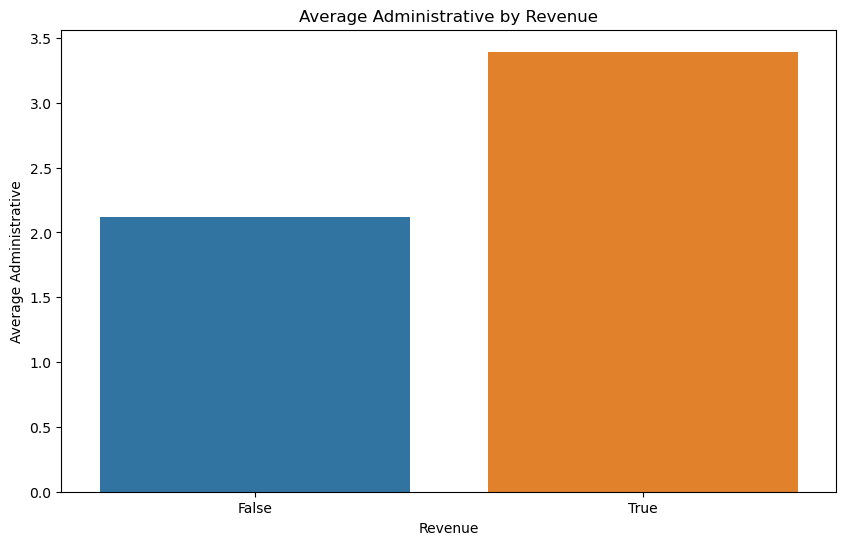

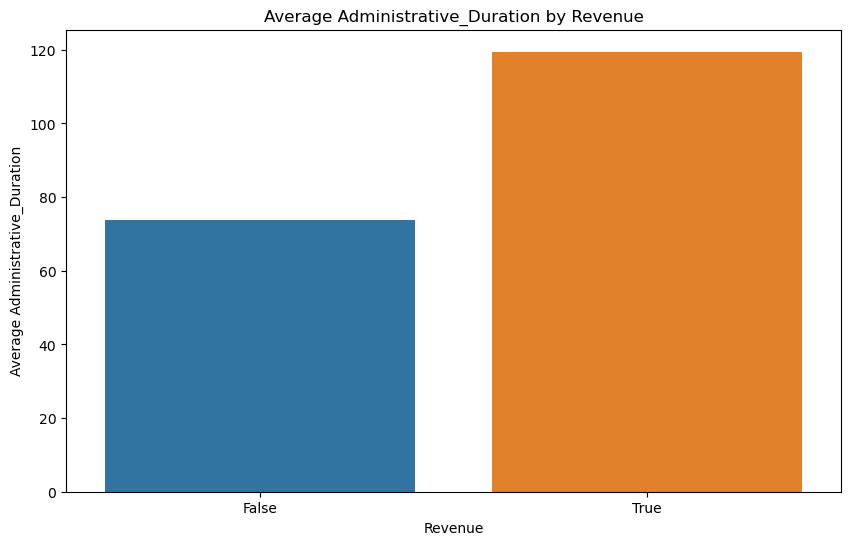

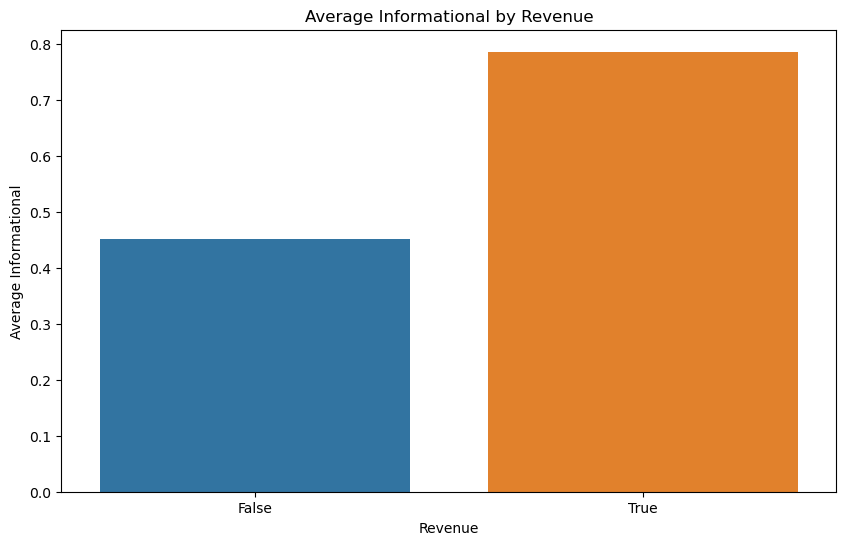

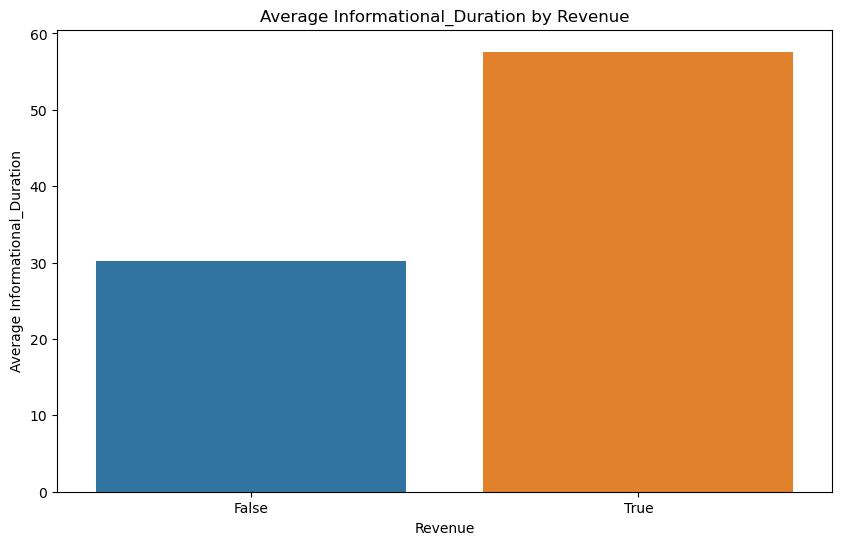

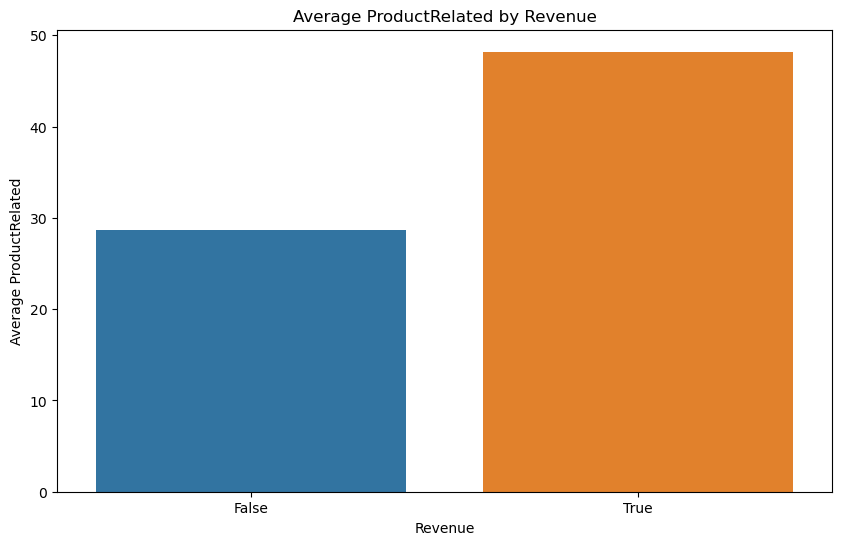

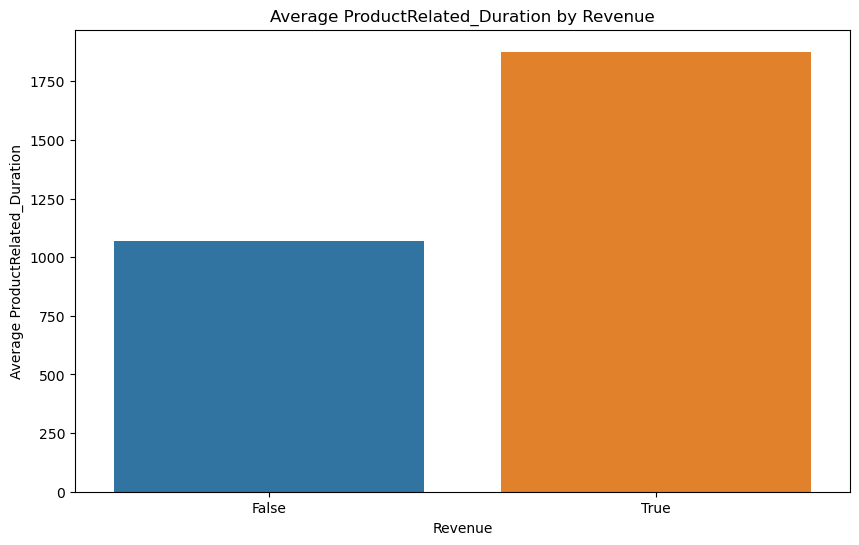

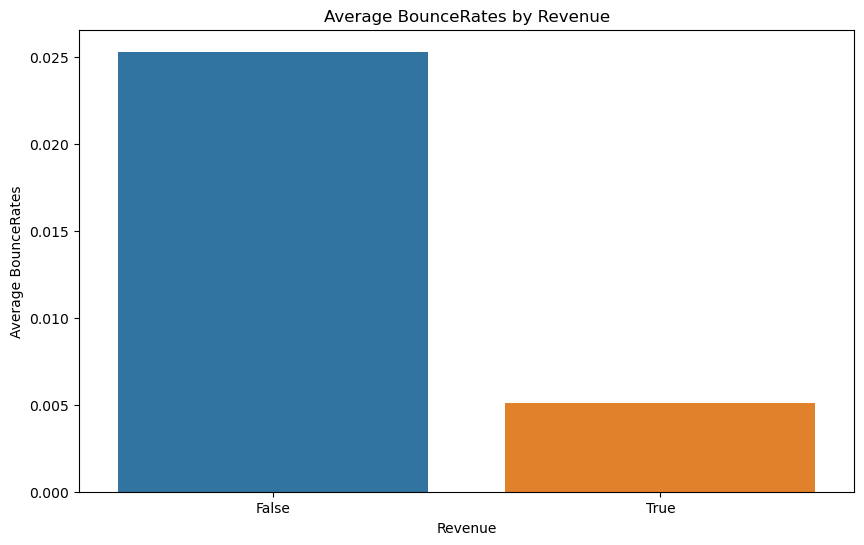

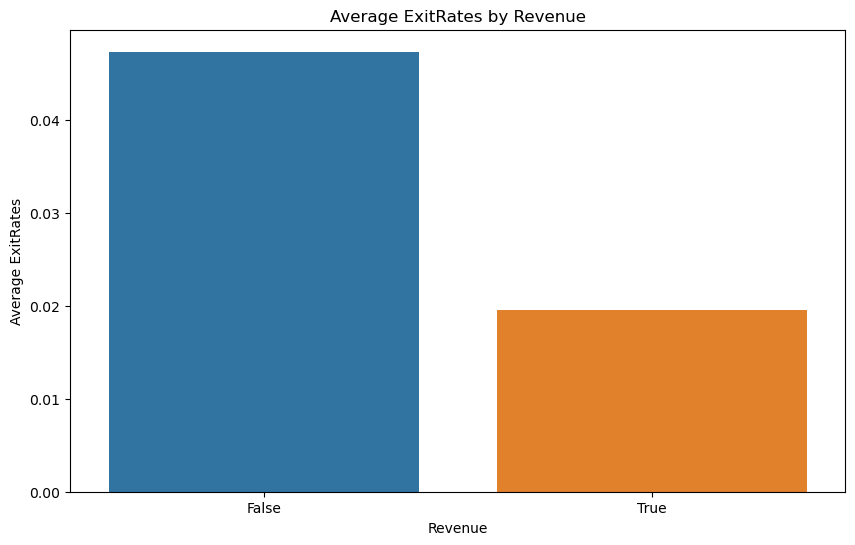

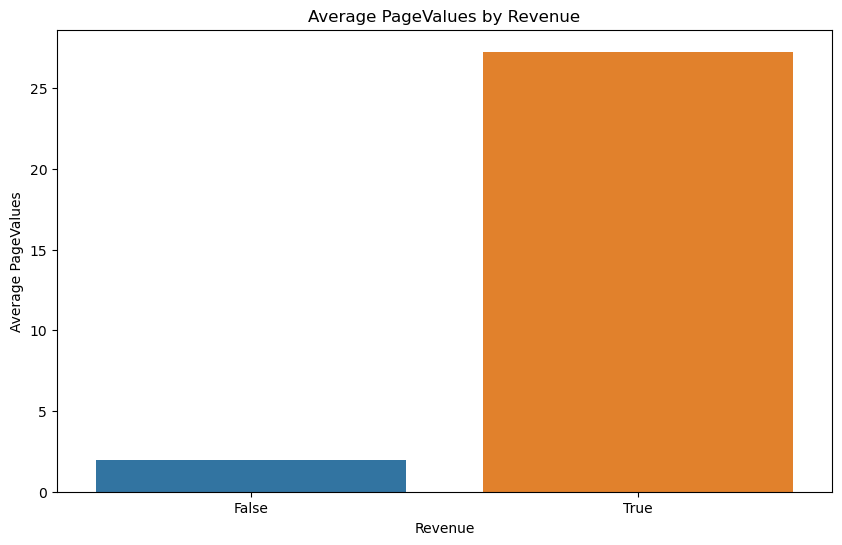

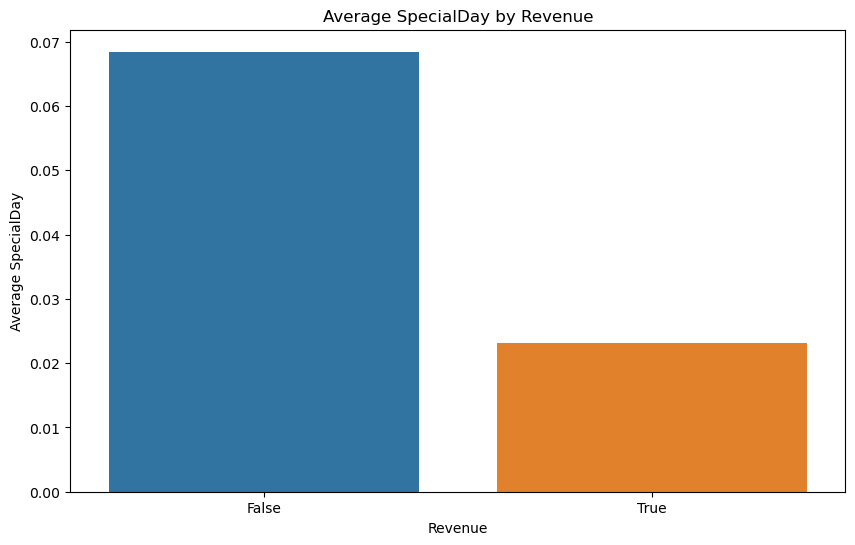

In [12]:
var_barplot = df[['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated',
               'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay' ]]

for column in var_barplot:
    plt.figure(figsize=(10, 6))
    
    sns.barplot(x='Revenue', y=column, data=df, errorbar=None)  # errorbar=None elimina las barras de error
    
     # Añadir título y etiquetas
    plt.title(f'Average {column} by Revenue')
    plt.xlabel('Revenue')
    plt.ylabel(f'Average {column}')
    
    # Mostrar el gráfico
    plt.show()

# Selección de variables

Mapa de correlación de calor, nos servirá para descartar variables que estén fuertemente correladas con otras.
También para ver linealidad positiva o negativa entre la variable dependiente y las demás. Resultado: no existe linealidad, 
todas están cercanas a 0, excepto PageValues.

<Axes: >

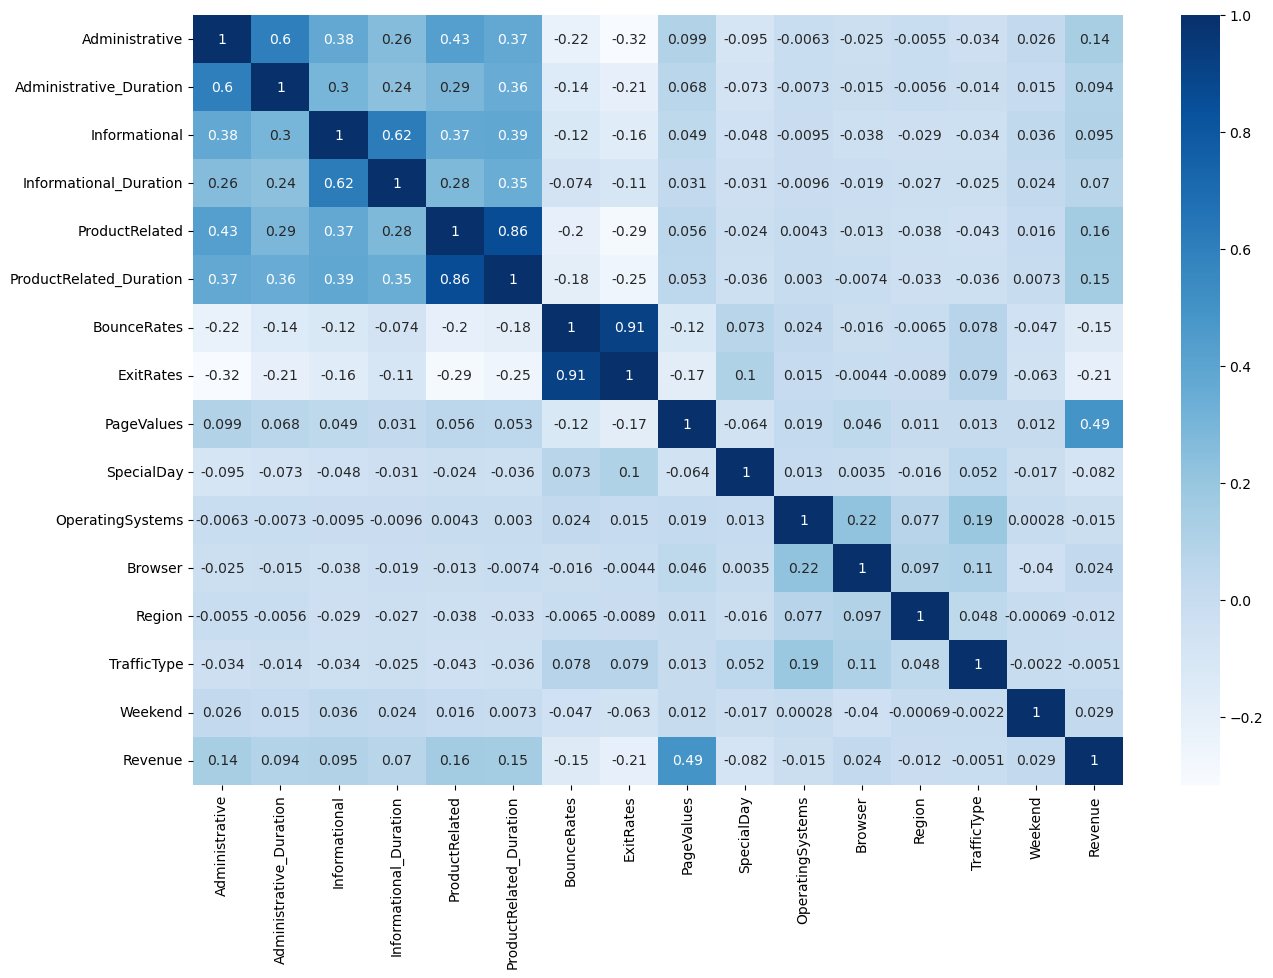

In [13]:
# Ver la correlación con heatmap puede darnos información para simplificar nuestro dataset.

# Vemos las siguientes correlaciones significativas, por encima de 0.85:
# ProductRelated_Duration ---> ProductRelated 
# ExitRates ---> BounceRates 
# Conservamos ProductRelated y BounceRates 

plt.figure(figsize = (15,10))
    
sns.heatmap(df.corr(numeric_only = True), cmap = 'Blues', annot = True)

In [14]:
# Hacemos una copia para empezar a modificar el dataset.

df2 = df.copy()

Se puede observar la correlación entre 2 variables y sus correladas. En este caso lo vamos a dejar así porque vamos a crear algunas nuevas features con estos campos. Anulo la siguiente celda. 



#Conservamos ProductRelated y BounceRates 

#df2 = df2.drop(['ProductRelated_Duration', 'ExitRates'], axis=1)

In [15]:
df2.head()


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


# Creación de nuevas features

In [17]:
# Crear la nueva feature: Tiempo total en el sitio
df2['Tiempo_Total_Sitio'] = df2['Administrative_Duration'] + df2['Informational_Duration'] + df2['ProductRelated_Duration']

# Mostrar el DataFrame actualizado con la nueva columna
df2.head(2)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,Tiempo_Total_Sitio
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False,0.0
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False,64.0


In [18]:
# Redondeamos todas las columnas de tipo float a 2 decimales

df2[df2.select_dtypes(include=['float']).columns] = df2.select_dtypes(include=['float']).round(2)


In [19]:
df2.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,Tiempo_Total_Sitio
0,0,0.0,0,0.0,1,0.00,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False,0.00
1,0,0.0,0,0.0,2,64.00,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False,64.00
2,0,0.0,0,0.0,1,0.00,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False,0.00
3,0,0.0,0,0.0,2,2.67,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False,2.67
4,0,0.0,0,0.0,10,627.50,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False,627.50


In [20]:
df2 = pd.get_dummies(df2, columns=['Month'], drop_first=False)


In [21]:
df2.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,0,0.0,0,0.0,1,0.00,0.20,0.20,0.0,0.0,...,False,False,True,False,False,False,False,False,False,False
1,0,0.0,0,0.0,2,64.00,0.00,0.10,0.0,0.0,...,False,False,True,False,False,False,False,False,False,False
2,0,0.0,0,0.0,1,0.00,0.20,0.20,0.0,0.0,...,False,False,True,False,False,False,False,False,False,False
3,0,0.0,0,0.0,2,2.67,0.05,0.14,0.0,0.0,...,False,False,True,False,False,False,False,False,False,False
4,0,0.0,0,0.0,10,627.50,0.02,0.05,0.0,0.0,...,False,False,True,False,False,False,False,False,False,False


In [22]:
# Convertir todas las columnas booleanas del DataFrame a 0 y 1
df2 = df2.applymap(lambda x: int(x) if isinstance(x, bool) else x)


In [23]:
df2.head(2)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0


In [24]:
df2.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                      int64
Revenue                      int64
Tiempo_Total_Sitio         float64
Month_Aug                    int64
Month_Dec                    int64
Month_Feb                    int64
Month_Jul                    int64
Month_June                   int64
Month_Mar                    int64
Month_May                    int64
Month_Nov                    int64
Month_Oct                    int64
Month_Sep                    int64
dtype: object

In [25]:
# Veo que me queda 1 campo object, lo paso a dummies.

In [26]:
df2['VisitorType'].unique()

array(['Returning_Visitor', 'New_Visitor', 'Other'], dtype=object)

In [27]:
value_counts = df2['VisitorType'].value_counts()
print("Conteo de registros por tipo de 'VisitorType':\n", value_counts)

Conteo de registros por tipo de 'VisitorType':
 VisitorType
Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: count, dtype: int64


In [28]:
# Aplicar get_dummies para 'VisitorType'
df2 = pd.get_dummies(df2, columns=['VisitorType'], drop_first=False)

# Convertir las columnas booleanas a 0 y 1
df2 = df2.applymap(lambda x: int(x) if isinstance(x, bool) else x)

# Verificar el resultado
print(df2.head())


   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                     0.00   
1                     0.0               2                    64.00   
2                     0.0               1                     0.00   
3                     0.0               2                     2.67   
4                     0.0              10                   627.50   

   BounceRates  ExitRates  PageValues  SpecialDay  ...  Month_Jul  Month_June  \
0         0.20       0.20         0.0         0.0  ...          0           0   
1         0.00       0.10         0.0         0.0 

In [29]:
df2.dtypes

Administrative                     int64
Administrative_Duration          float64
Informational                      int64
Informational_Duration           float64
ProductRelated                     int64
ProductRelated_Duration          float64
BounceRates                      float64
ExitRates                        float64
PageValues                       float64
SpecialDay                       float64
OperatingSystems                   int64
Browser                            int64
Region                             int64
TrafficType                        int64
Weekend                            int64
Revenue                            int64
Tiempo_Total_Sitio               float64
Month_Aug                          int64
Month_Dec                          int64
Month_Feb                          int64
Month_Jul                          int64
Month_June                         int64
Month_Mar                          int64
Month_May                          int64
Month_Nov       

In [31]:
df2.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,BounceRates,PageValues,SpecialDay,OperatingSystems,Browser,...,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.20,0.0,0.0,1,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0.0,0,0.0,2,0.00,0.0,0.0,2,2,...,0,0,0,0,0,0,0,0,0,1
2,0,0.0,0,0.0,1,0.20,0.0,0.0,4,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0.0,0,0.0,2,0.05,0.0,0.0,3,2,...,0,0,0,0,0,0,0,0,0,1
4,0,0.0,0,0.0,10,0.02,0.0,0.0,3,3,...,0,0,0,0,0,0,0,0,0,1


### Dividimos muestra en train y test y estandarizamos

In [30]:
x = df2.drop('Revenue', axis = 1) # Features
y = df2['Revenue'] # Target

Aplicamos el método SelectKBest para elegir las 10 mejores variables y probar los modelos con esta reducción de dimensionalidad.
* Vemos cómo SelectKBest elige la nueva feature como una de las mejores.

La siguientes 2 celdas se añade respecto al notebook original

In [70]:
# Aplicar SelectKBest
k = 10  # Seleccionar las 10 mejores características
selector = SelectKBest(score_func=f_classif, k=k)
x_new = selector.fit_transform(x, y)

In [71]:
# Ver las características seleccionadas
selected_features = selector.get_support(indices=True)
selected_columns = x.columns[selected_features]
# Forzar la eliminación de 'Month_Nov' si fue seleccionada
selected_columns = [col for col in selected_columns if col != 'Month_Nov']

print("Selected features:", selected_columns)

Selected features: ['Administrative', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'Tiempo_Total_Sitio', 'VisitorType_New_Visitor', 'VisitorType_Returning_Visitor']


In [72]:
x_selected = x[selected_columns]

x_selected.head()

,Administrative,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,Tiempo_Total_Sitio,VisitorType_New_Visitor,VisitorType_Returning_Visitor
0,0,1,0.00,0.20,0.20,0.0,0.00,0,1
1,0,2,64.00,0.00,0.10,0.0,64.00,0,1
2,0,1,0.00,0.20,0.20,0.0,0.00,0,1
3,0,2,2.67,0.05,0.14,0.0,2.67,0,1
4,0,10,627.50,0.02,0.05,0.0,627.50,0,1


In [73]:
x = x_selected

In [74]:
x.head()

,Administrative,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,Tiempo_Total_Sitio,VisitorType_New_Visitor,VisitorType_Returning_Visitor
0,0,1,0.00,0.20,0.20,0.0,0.00,0,1
1,0,2,64.00,0.00,0.10,0.0,64.00,0,1
2,0,1,0.00,0.20,0.20,0.0,0.00,0,1
3,0,2,2.67,0.05,0.14,0.0,2.67,0,1
4,0,10,627.50,0.02,0.05,0.0,627.50,0,1


In [75]:
# Dividimos el dataset en entrenamiento y test (70/30)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

In [76]:
# Escalamos sobre train

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [77]:
# Verificar que x_train y x_test tienen las 10 columnas seleccionadas
print("Shape de x_train:", x_train.shape)
print("Shape de x_test:", x_test.shape)

Shape de x_train: (8631, 9)
Shape de x_test: (3699, 9)


### Regresión logística

In [78]:
log = LogisticRegression()
log.fit(x_train, y_train)

LogisticRegression()

In [79]:
y_train_prob_log  = log.predict_proba(x_train) # probabilidades devueltas por el modelo para train
y_test_prob_log  = log.predict_proba(x_test) # probabilidades devueltas por el modelo para test

In [80]:
y_test_prob_log

array([[0.90861766, 0.09138234],
       [0.80797103, 0.19202897],
       [0.86033504, 0.13966496],
       ...,
       [0.88580126, 0.11419874],
       [0.87815771, 0.12184229],
       [0.95495247, 0.04504753]])

In [81]:
y_test_prob_log[:,1] # probabilidad de target = 1

array([0.09138234, 0.19202897, 0.13966496, ..., 0.11419874, 0.12184229,
       0.04504753])

Curva ROC y AUC

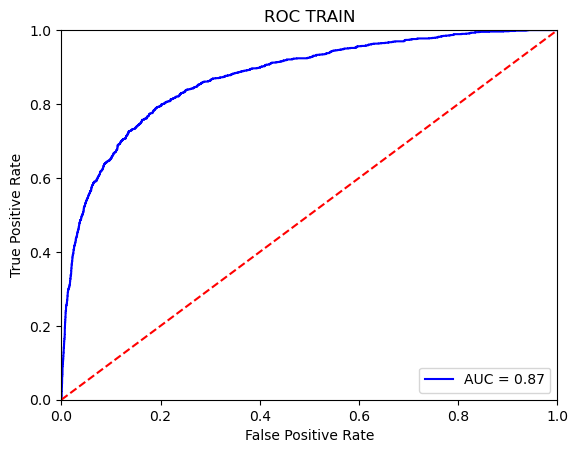

In [82]:
represento_curva_roc(y_train, y_train_prob_log, 'ROC TRAIN')

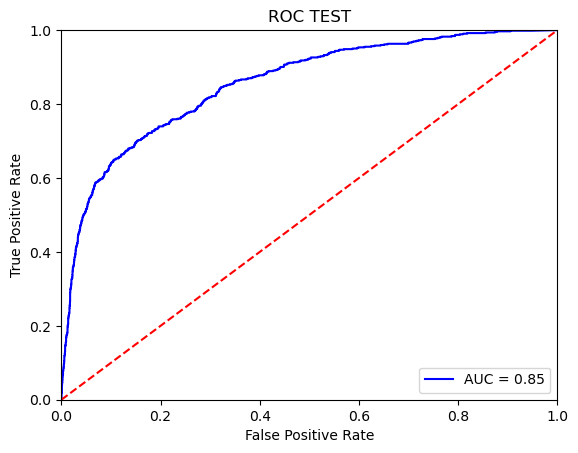

In [83]:
represento_curva_roc(y_test, y_test_prob_log, 'ROC TEST')

Métricas matriz de confusión


Las probabilidades que devuelve el modelo son valores continuos entre 0 y 1. Para pasarlo a 0s y a 1s (necesario para la matriz de confusión) es necesario usar un umbral de corte. Aquellas observaciones cuya probabilidad predicha sea superior al umbral definido tendrá predicción = 1, en caso contrario predicción = 0.

In [84]:
umbral = 0.5
y_test_pred_log = 1*(y_test_prob_log[:, 1] > umbral)

In [85]:
y_test_pred_log

array([0, 0, 0, ..., 0, 0, 0])

In [86]:
confusion_matrix(y_test, y_test_pred_log)

array([[3033,   44],
       [ 483,  139]], dtype=int64)

<Axes: >

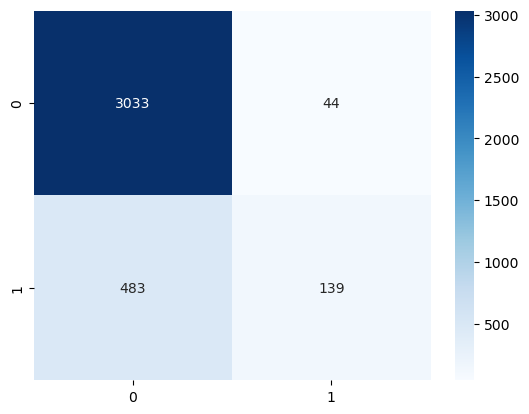

In [87]:
sns.heatmap(confusion_matrix(y_test, y_test_pred_log), annot=True, cmap = 'Blues', fmt='d')

In [88]:
print('accuracy')
print(round(accuracy_score(y_test, y_test_pred_log), 2))

print('precision')
print(round(precision_score(y_test, y_test_pred_log), 2))

print('recall')
print(round(recall_score(y_test, y_test_pred_log), 2))

accuracy
0.86
precision
0.76
recall
0.22


Resultados:

1. Umbral 0.5

accuracy
0.86
precision
0.77
recall
0.23

2. Umbral 0.1

accuracy
0.66
precision
0.32
recall
0.91

3. Umbral 0.8

accuracy
0.84
precision
0.8
recall
0.09


Conclusiones: depende de lo que persigamos para nuestro modelo deberemos ajustar el umbral, supongamos que queremos identificar todos los usuarios que acabarán comprando para no hacerles llegar una promoción durante la navegación, ya que sabemos que en esos usuarios no es necesario. Buscaremos un recall alto, lo que significa que estamos capturando casi todas las instancias positivas. Así conseguiremos no enviar descuentos o promociones a probables compradores.

La regresión logística no nos presenta un buen modelo predictivo, continuemos probando otros.

# KNN

Conclusión: el modelo KNN no arroja mejores resultados en general, iguala accuracy pero no mejora AUC

* Con la selección de las 10 mejores variables con el método SelectKBest ha mejorado AUC considerablemente, ha pasado de 0.89 en train y 0.7 en test a 0.94 y 0.84 respectivamente. También mejoran accuracy, recall y F1-score.

In [89]:
params = {'n_neighbors': range(1,15)}

knn = KNeighborsClassifier()

knn_cv = GridSearchCV(knn, params, cv=3)

knn_cv.fit(x_train,y_train)

knn_cv.best_params_

{'n_neighbors': 13}

In [90]:
knn =  KNeighborsClassifier(n_neighbors=knn_cv.best_params_['n_neighbors'])

knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=13)

In [91]:
y_train_prob_knn  = knn.predict_proba(x_train)
y_test_prob_knn  = knn.predict_proba(x_test)

fpr, tpr, threshold = roc_curve(y_train, y_train_prob_knn[:, 1])
print("AUC train = ", round(auc(fpr, tpr), 2))

fpr, tpr, threshold = roc_curve(y_test, y_test_prob_knn[:, 1])
print("AUC test = ", round(auc(fpr, tpr), 2))

AUC train =  0.93
AUC test =  0.84


In [92]:
# Hacer predicciones en los conjuntos de entrenamiento y prueba
y_train_pred_knn = knn.predict(x_train)
y_test_pred_knn = knn.predict(x_test)

# Obtener la matriz de confusión para el conjunto de prueba
conf_matrix_test = confusion_matrix(y_test, y_test_pred_knn)
print("Confusion Matrix (Test):")
print(conf_matrix_test)


Confusion Matrix (Test):
[[2993   84]
 [ 363  259]]


In [93]:
# Obtener el reporte de clasificación
print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_knn))

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      3077
           1       0.76      0.42      0.54       622

    accuracy                           0.88      3699
   macro avg       0.82      0.69      0.73      3699
weighted avg       0.87      0.88      0.86      3699



In [94]:
# Obtener la precisión (accuracy) del conjunto de prueba
test_accuracy = accuracy_score(y_test, y_test_pred_knn)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.8791565287915653


In [95]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

knn = KNeighborsClassifier(n_neighbors=knn_cv.best_params_['n_neighbors'])
knn.fit(x_train_scaled, y_train)
y_test_pred_knn = knn.predict(x_test_scaled)


from sklearn.metrics import roc_curve, auc

# Obtener probabilidades de prueba
y_test_prob_knn = knn.predict_proba(x_test_scaled)[:, 1]

# Ajuste del umbral
umbrales = [0.2, 0.4, 0.5, 0.6, 0.7, 0.8]
for umbral in umbrales:
    y_test_pred_knn = (y_test_prob_knn > umbral).astype(int)
    print(f"\nUmbral: {umbral}")
    print("Accuracy:", accuracy_score(y_test, y_test_pred_knn))
    print("Precision:", precision_score(y_test, y_test_pred_knn))
    print("Recall:", recall_score(y_test, y_test_pred_knn))
    print("F1-Score:", f1_score(y_test, y_test_pred_knn))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred_knn))



Umbral: 0.2
Accuracy: 0.8426601784266018
Precision: 0.5224719101123596
Recall: 0.747588424437299
F1-Score: 0.6150793650793651
Confusion Matrix:
[[2652  425]
 [ 157  465]]

Umbral: 0.4
Accuracy: 0.8761827520951608
Precision: 0.6626984126984127
Recall: 0.5369774919614148
F1-Score: 0.5932504440497335
Confusion Matrix:
[[2907  170]
 [ 288  334]]

Umbral: 0.5
Accuracy: 0.8802379021357124
Precision: 0.7115839243498818
Recall: 0.48392282958199356
F1-Score: 0.5760765550239234
Confusion Matrix:
[[2955  122]
 [ 321  301]]

Umbral: 0.6
Accuracy: 0.8772641254393079
Precision: 0.7372881355932204
Recall: 0.41961414790996787
F1-Score: 0.5348360655737706
Confusion Matrix:
[[2984   93]
 [ 361  261]]

Umbral: 0.7
Accuracy: 0.8718572587185726
Precision: 0.8109243697478992
Recall: 0.3102893890675241
F1-Score: 0.44883720930232557
Confusion Matrix:
[[3032   45]
 [ 429  193]]

Umbral: 0.8
Accuracy: 0.8696945120302785
Precision: 0.8804347826086957
Recall: 0.2604501607717042
F1-Score: 0.40198511166253104
Conf

### Clasificación: Random Forest

In [100]:
params = {'n_estimators': [200, 300], "min_samples_split": [10, 30, 50], "max_depth": [4, 6, 8]}
# Estos parámetros dan AUC train = 0.95 y AUC test = 0.92

# params = {'n_estimators': [100, 200, 300, 400, 500], "min_samples_split": [10, 30, 50], "max_depth": [4, 6, 8]}
# Aumentar el número de árboles no mejora los resultados anteriores

#params = {'n_estimators': [200, 300], "min_samples_split": [2, 5, 10, 20, 30, 50], "max_depth": [4, 6, 8, 10, 12, None]}
# Aumentar min_samples_split ( número mínimo de muestras requeridas para dividir un nodo) sube el AUC traina a 0.95 y AUC 
# test a 0.93
# Aumentar max_depth": [4, 6, 8, 10, 12, None aumenta AUC train a 0.97 pero deja igual AUC test = 0.93

rf = RandomForestClassifier()

rf_cv = GridSearchCV(rf, params, cv=3)

rf_cv.fit(x_train,y_train)

rf_cv.best_params_

{'max_depth': 6, 'min_samples_split': 50, 'n_estimators': 300}

In [101]:
rf =  RandomForestClassifier(n_estimators=rf_cv.best_params_['n_estimators'], 
                             min_samples_split = rf_cv.best_params_['min_samples_split'], 
                             max_depth = rf_cv.best_params_['max_depth'],
                            random_state = 0)

rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=6, min_samples_split=50, n_estimators=300,
                       random_state=0)

In [102]:
y_train_prob_rf  = rf.predict_proba(x_train)
y_test_prob_rf  = rf.predict_proba(x_test)

fpr, tpr, threshold = roc_curve(y_train, y_train_prob_rf[:, 1])
print("AUC train = ", round(auc(fpr, tpr), 2))

fpr, tpr, threshold = roc_curve(y_test, y_test_prob_rf[:, 1])
print("AUC test = ", round(auc(fpr, tpr), 2))

AUC train =  0.93
AUC test =  0.9


Los resultados de AUC con Random Forest son bastante buenos, pero hay que tener en cuenta el accuracy y recall para acercarnos al objetivo supuesto de clasificar correctamente los clientes que no van a comprar en nuestra web, para ello tenemos que conseguir que el número de falsos negativos sea bajo.

Vamos a ver los resultados para varios umbrales en las siguientes celdas.

Conclusión: para dirigir una campaña para el supuesto que he planteado, un umbral de 0.2 da un porcentaje alto de verdaderos negativos y uno bajo de falsos negativos (119), que son negativos mal predichos, solo un 3% al que no podremos dirigir nuestra campaña de incentivos, a lo que hay que sumarle los falsos positivos. 

In [103]:
# Probamos diferentes umbrales
umbrales = [0.2, 0.4, 0.5, 0.6, 0.7, 0.8]
for umbral in umbrales:
    y_test_pred_rf = (y_test_prob_rf[:, 1] > umbral).astype(int)
    print(f"Umbral: {umbral}")
    print("Accuracy:", accuracy_score(y_test, y_test_pred_rf))
    print("Precision:", precision_score(y_test, y_test_pred_rf))
    print("Recall:", recall_score(y_test, y_test_pred_rf))
    print("F1-Score:", f1_score(y_test, y_test_pred_rf))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred_rf))
    print("-" * 50)


Umbral: 0.2
Accuracy: 0.8699648553663152
Precision: 0.5826494724501758
Recall: 0.7990353697749196
F1-Score: 0.6738983050847458
Confusion Matrix:
[[2721  356]
 [ 125  497]]
--------------------------------------------------
Umbral: 0.4
Accuracy: 0.8886185455528521
Precision: 0.6688102893890675
Recall: 0.6688102893890675
F1-Score: 0.6688102893890675
Confusion Matrix:
[[2871  206]
 [ 206  416]]
--------------------------------------------------
Umbral: 0.5
Accuracy: 0.884022708840227
Precision: 0.7281323877068558
Recall: 0.49517684887459806
F1-Score: 0.5894736842105264
Confusion Matrix:
[[2962  115]
 [ 314  308]]
--------------------------------------------------
Umbral: 0.6
Accuracy: 0.8807785888077859
Precision: 0.8047138047138047
Recall: 0.3842443729903537
F1-Score: 0.5201305767138193
Confusion Matrix:
[[3019   58]
 [ 383  239]]
--------------------------------------------------
Umbral: 0.7
Accuracy: 0.8699648553663152
Precision: 0.873015873015873
Recall: 0.2652733118971061
F1-Score: 0

# Keras - clasificación

En este modelo de redes neuronales se mejoran los resultados al aumentar el número de neuronas, en una primera prueba he asignado 1, 8 y 12 y en esta segunta 1, 32 y 64.

* Respecto a la reducción de variables a 10, los resultados son muy similares y disminuye el tiempo de ejecución considerablemente. 

In [104]:
# Definir el número de neuronas de entrada basado en el número de variables input
n_features = x_train.shape[1]

In [105]:
print (n_features)

9


In [106]:
# Crear el modelo secuencial
model = Sequential()

# Primera capa con la especificación del número de características de entrada
model.add(Dense(64, input_dim=n_features, activation='relu'))

# Otras capas del modelo
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))




C:\Users\Antonio\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [107]:
# Compilar el modelo

model.compile(optimizer='adam',
                          loss='binary_crossentropy',
                          metrics=['accuracy', AUC(), Recall()])


In [108]:
# Ajuste del modelo

early_stop = EarlyStopping(patience = 20)

modelo_multi_layer = model.fit(x_train, y_train, 
                               epochs=150, batch_size=20, verbose = 2, 
                               validation_data = (x_test, y_test), callbacks=[early_stop])

Epoch 1/150
432/432 - 4s - 9ms/step - accuracy: 0.8548 - auc_1: 0.7315 - loss: 0.3807 - recall_1: 0.0358 - val_accuracy: 0.8497 - val_auc_1: 0.8236 - val_loss: 0.3548 - val_recall_1: 0.1350
Epoch 2/150
432/432 - 1s - 3ms/step - accuracy: 0.8836 - auc_1: 0.8601 - loss: 0.2953 - recall_1: 0.3157 - val_accuracy: 0.8721 - val_auc_1: 0.8657 - val_loss: 0.3168 - val_recall_1: 0.3441
Epoch 3/150
432/432 - 1s - 3ms/step - accuracy: 0.8924 - auc_1: 0.8839 - loss: 0.2720 - recall_1: 0.4222 - val_accuracy: 0.8813 - val_auc_1: 0.8761 - val_loss: 0.3016 - val_recall_1: 0.4486
Epoch 4/150
432/432 - 1s - 2ms/step - accuracy: 0.8939 - auc_1: 0.8918 - loss: 0.2643 - recall_1: 0.4743 - val_accuracy: 0.8819 - val_auc_1: 0.8783 - val_loss: 0.2968 - val_recall_1: 0.4727
Epoch 5/150
432/432 - 1s - 3ms/step - accuracy: 0.8967 - auc_1: 0.8960 - loss: 0.2578 - recall_1: 0.4883 - val_accuracy: 0.8838 - val_auc_1: 0.8831 - val_loss: 0.2906 - val_recall_1: 0.5016
Epoch 6/150
432/432 - 1s - 3ms/step - accuracy: 0.

Epoch 44/150
432/432 - 1s - 2ms/step - accuracy: 0.9045 - auc_1: 0.9129 - loss: 0.2332 - recall_1: 0.5350 - val_accuracy: 0.8851 - val_auc_1: 0.8953 - val_loss: 0.2752 - val_recall_1: 0.5113
Epoch 45/150
432/432 - 1s - 2ms/step - accuracy: 0.9040 - auc_1: 0.9120 - loss: 0.2338 - recall_1: 0.5443 - val_accuracy: 0.8862 - val_auc_1: 0.8972 - val_loss: 0.2728 - val_recall_1: 0.5370
Epoch 46/150
432/432 - 1s - 2ms/step - accuracy: 0.9041 - auc_1: 0.9128 - loss: 0.2332 - recall_1: 0.5249 - val_accuracy: 0.8878 - val_auc_1: 0.8964 - val_loss: 0.2768 - val_recall_1: 0.5595
Epoch 47/150
432/432 - 1s - 2ms/step - accuracy: 0.9040 - auc_1: 0.9139 - loss: 0.2329 - recall_1: 0.5350 - val_accuracy: 0.8835 - val_auc_1: 0.8986 - val_loss: 0.2734 - val_recall_1: 0.4839
Epoch 48/150
432/432 - 1s - 2ms/step - accuracy: 0.9051 - auc_1: 0.9139 - loss: 0.2321 - recall_1: 0.5420 - val_accuracy: 0.8878 - val_auc_1: 0.8963 - val_loss: 0.2787 - val_recall_1: 0.5531
Epoch 49/150
432/432 - 1s - 2ms/step - accura

In [112]:
# Obtención de métricas y resultados

pd.DataFrame(modelo_multi_layer.history).tail()

,accuracy,auc_1,loss,recall_1,val_accuracy,val_auc_1,val_loss,val_recall_1
76,0.906732,0.915852,0.228659,0.545879,0.887537,0.899059,0.275372,0.503215
77,0.905109,0.916249,0.228776,0.540435,0.885645,0.898275,0.280422,0.464630
78,0.905921,0.916286,0.228313,0.545101,0.886456,0.899738,0.276728,0.519293
79,0.905689,0.917483,0.227553,0.535770,0.889970,0.899606,0.276574,0.573955
80,0.906616,0.916759,0.227968,0.549767,0.889430,0.898568,0.273903,0.581994


In [113]:
model.evaluate(x_train, y_train)

270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9120 - auc_1: 0.9183 - loss: 0.2223 - recall_1: 0.6315


[0.22746530175209045,
 0.9076584577560425,
 0.9183805584907532,
 0.6096423268318176]

In [114]:
model.evaluate(x_test, y_test)

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8856 - auc_1: 0.8890 - loss: 0.2843 - recall_1: 0.5517


[0.27390316128730774,
 0.8894295692443848,
 0.8985683917999268,
 0.581993579864502]

****************************